# Lockdown Multilevel Model - Random Intercept & Random Slopes

In [2]:
import os
sys.path.append("C:\\Users\\Andrew\\OneDrive - University College London\\_PhD\\Papers - Drafts\\J5_JASA_Lockdown-SS")

from scripts import lockdown_mlm as mlm
import pandas as pd
from pathlib import Path
import numpy as np
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scripts import lockdown_mlm_rirs as rirs

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_context("paper", font_scale=1.4)

# Define some constants and options
## variables
dep_vars = ["Natural", "Traffic", "Human", "Other", "loudness", "overall", "Pleasant", "Eventful"]

FEATS_LISTS = mlm.FEATS_LISTS
remove = ["FS_TEMP", "LAeq_TEMP", "LCeq_TEMP", "LZeq_TEMP", "I_TEMP", "N_TEMP", "R_TEMP", "S_TEMP", "SIL_TEMP", "THD_TEMP", "T_TEMP"]

for k in remove:
    FEATS_LISTS.pop(k, None)

acoustic_vars = sorted({x for v in FEATS_LISTS.values() for x in v})

## processing options
nonlinear_transformations = [] # Leave a blank list to do no transformations
criterion = "aic"

# ##################################################################
# Load Data

DATA_DIR = Path("C:/Users/Andrew/OneDrive - University College London/_PhD/Papers - Drafts/J5_JASA_Lockdown-SS/data")
RESULTS_DIR = Path("C:/Users/Andrew/OneDrive - University College London/_PhD/Papers - Drafts/J5_JASA_Lockdown-SS/results")
ssidData = pd.read_csv(DATA_DIR.joinpath("2020-08-13/LondonVeniceBINResults_2020-08-13_4.csv"))

for col_name in ["Lockdown"]:
    ssidData[col_name] = ssidData[col_name].astype('category')

# Cutdown the dataset
cols = ["GroupID", "LocationID", "SessionID", "Lockdown"] + dep_vars + acoustic_vars
ssidData = ssidData[cols]

# Compress to mean of each GroupID
# compressData = ssidData.copy()
compressData = ssidData.groupby(["GroupID"]).mean()
compressData = compressData.merge(ssidData[["GroupID", "LocationID", "SessionID", "Lockdown"]].drop_duplicates(),  on="GroupID")

location_codes = pd.Categorical(compressData["LocationID"]).codes
compressData["LocationID_codes"] = location_codes
compressData.loc[compressData["Lockdown"] == 1].dropna(inplace=True)
compressData = compressData.dropna(subset=acoustic_vars)

compressData, acoustic_vars = mlm.nonlinear_features(compressData, acoustic_vars, transformations=nonlinear_transformations)
print("Initial features number:    ", len(acoustic_vars))

# Standardise
from sklearn.preprocessing import StandardScaler
compressData = compressData.replace([np.inf, -np.inf], np.nan)
compressData = compressData.dropna(subset=acoustic_vars)
scaler = StandardScaler()
compressData[acoustic_vars] = scaler.fit_transform(compressData[acoustic_vars])


# ###############################################################
# Split Prelockdown from during lockdown
prelockdownData = compressData.loc[compressData["Lockdown"] == 1]
prelockdownData = prelockdownData.dropna()
print("prelockdownData shape:     ", prelockdownData.shape)
lockdownData = compressData.loc[compressData["Lockdown"] == 2]
print("during lockdownData shape: ", lockdownData.shape)


Initial features number:     119
prelockdownData shape:      (661, 132)
during lockdownData shape:  (573, 132)


In [3]:
from sklearn.model_selection import train_test_split
prelockdownTrain, prelockdownTest = train_test_split(prelockdownData, test_size = 0.25, random_state = 42)

## Feature Selection and Model Building

### Backward step feature selection
In order to filter out the massive number of potential features, we want to determine which ones significantly contribute to the final model. To do this, we use backward step feature selection which starts by including all possible features and gradually reduces them based on their p-values. This follows 6 steps:

[](https://miro.medium.com/max/700/1*Jub_nEYtN0htxFpTRzRtBQ.png)

#### Step 1
Select a significance level to use as the criterion for selection. Typically, this will be 0.05.

#### Step 2
Fit the model with all the features selected.

#### Step 3
Identify the feature with the highest p-value (i.e. least statistically significant).

#### Step 4
If the p-value of this feature is greater than the significance level (e.g. p-value is > 0.05), we remove it from the feature set. If the highest p-value is less than the significance level, skip to step 6 and finish.

#### Step 5
Remove the feature from the set and fit a new model. Return to step 3 and repeat until all features have a p-value below the significance level.

#### Step 6
We have now identified the feature set, so fit the final model.

This results in a drastically cut down feature set, which is good, but it's still a very complex model, resulting in a low adjusted r-squared value. We've identified all of the potentially significant features, but we still need to do further feature selection. For this, we move onto forward step feature selection with the Akaike Information Criterion as our criterion.

### Forward Step Feature selection
https://planspace.org/20150423-forward_selection_with_statsmodels/

In forward step selection, we build a model for each potential feature individually, calculate the best performing model, and select that feature. We then add every other feature to it and build n-1 two-feature models, then calculate the best performing model and select those two features. This continues until adding features to the model no longer improves its criterion performance. 

It is important in this method to use a criterion which punishes model complexity, otherwise the model will always improve by adding new features.

Success! We can see that this method has reduced the features even further. However, I suspect there are some issues with multicollinearity, so we'll tackle that next.

### Reducing multi-collinearity
We've identified multi-collinearity among several of the features which were selected by the backward-forward feature selection. This is identified through the Variance Inflation Factor (VIF). We've set the max acceptable VIF at a fairly high level of 10 to be very lenient to our potential features. To address this, we remove the highest VIF feature and re-build the model, then check the VIF again. We do this until the max VIF feature is below our set criterion.

### Partial correlation filtering
For an alternative filtering method we can use partial correlation. 
With this filtering method, we run a partial correlation for each type of feature. For instance, we have several LAeq statistics measures (LAeq, LAeq_5, LAeq_10, etc). We know we won't want to use all of them, so we determine which feature within each type subset has the highest correlation value (when controlling for LocationID) and use that one. 

This results in a list of candidate features, ready to go through further feature selection.


## Random Intercept Random Slope model feature selection
The above procedure was developed for a random intercept only model structure. Unfortunately, it is not possible for me to fit a RIRS model with the full set of features as required by the backward step method. In addition, once a random slope structure is introduced, most of the features come up as non-significant, so they would all get removed by the backward step method. 

So we skipe the backward step feature selection and only do Forward step, then VIF reduction.

## Pleasant Model


Running Forward step feature selection.
1|selected: ['SIL_50']  |  aic:  311.0558
2|selected: ['SIL_50', 'LZeq']  |  aic:  301.3902
3|selected: ['SIL_50', 'LZeq', 'THD_95']  |  aic:  299.0
4|selected: ['SIL_50', 'LZeq', 'THD_95', 'PeakSpectralCentroid']  |  aic:  295.9082
5|selected: ['SIL_50', 'LZeq', 'THD_95', 'PeakSpectralCentroid', 'LZeq_10_LZeq_90']  |  aic:  295.243
6|selected: ['SIL_50', 'LZeq', 'THD_95', 'PeakSpectralCentroid', 'LZeq_10_LZeq_90', 'I_10']  |  aic:  292.4942
7|selected: ['SIL_50', 'LZeq', 'THD_95', 'PeakSpectralCentroid', 'LZeq_10_LZeq_90', 'I_10', 'I']  |  aic:  291.1188
8|selected: ['SIL_50', 'LZeq', 'THD_95', 'PeakSpectralCentroid', 'LZeq_10_LZeq_90', 'I_10', 'I']  |  aic:  291.1188


Pleasant ~ SIL_50 + LZeq + THD_95 + PeakSpectralCentroid + LZeq_10_LZeq_90 + I_10 + I
                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           Pleasant 
No. Observations:           661              

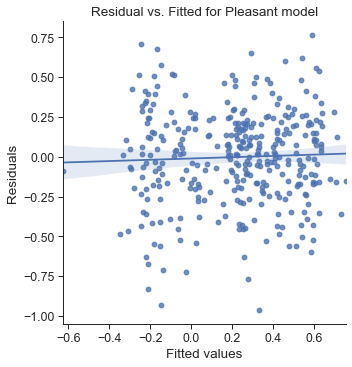

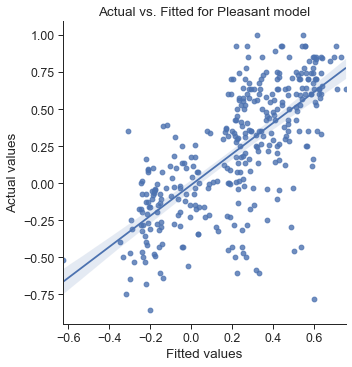

Adj R-sq:  0.4341674008589852


In [3]:
Pleasant_rirs_results = mlm.mlm_feature_selection(prelockdownData, "Pleasant", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

Pleasant_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/Pleasant_rirs_model_1.pickle")))
Pleasant_rirs_results["performance"] = mlm.summarise_model(Pleasant_rirs_results["final_model_fit"], prelockdownData)

## Eventful Model


Running Forward step feature selection.
1|selected: ['R_50']  |  aic:  114.3478
2|selected: ['R_50', 'LAeq_Min']  |  aic:  105.0016
3|selected: ['R_50', 'LAeq_Min', 'LCeq_Min']  |  aic:  99.3806
4|selected: ['R_50', 'LAeq_Min', 'LCeq_Min', 'R_90']  |  aic:  97.1542
5|selected: ['R_50', 'LAeq_Min', 'LCeq_Min', 'R_90']  |  aic:  97.1542


Eventful ~ R_50 + LAeq_Min + LCeq_Min + R_90
               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Eventful
No. Observations:       661         Method:                 ML      
No. Groups:             13          Scale:                  0.0630  
Min. group size:        11          Log-Likelihood:         -44.5771
Max. group size:        81          Converged:              No      
Mean group size:        50.8                                        
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------

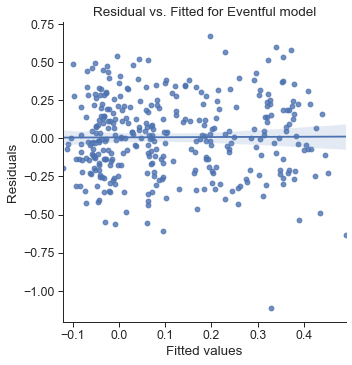

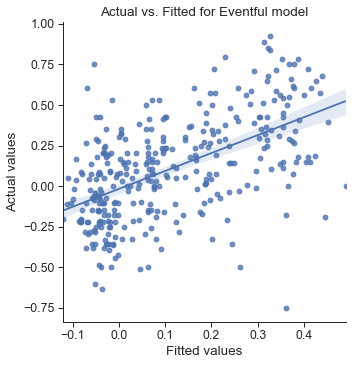

Adj R-sq:  0.25374907921619305


In [4]:
Eventful_rirs_results = mlm.mlm_feature_selection(prelockdownData, "Eventful", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

Eventful_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/Eventful_rirs_model_1.pickle")))
Eventful_rirs_results["performance"] = mlm.summarise_model(Eventful_rirs_results["final_model_fit"], prelockdownData)

Now we can plot the fitted results on the circumplex model to visualise how the model is treating the data.

**Fitted Results:**

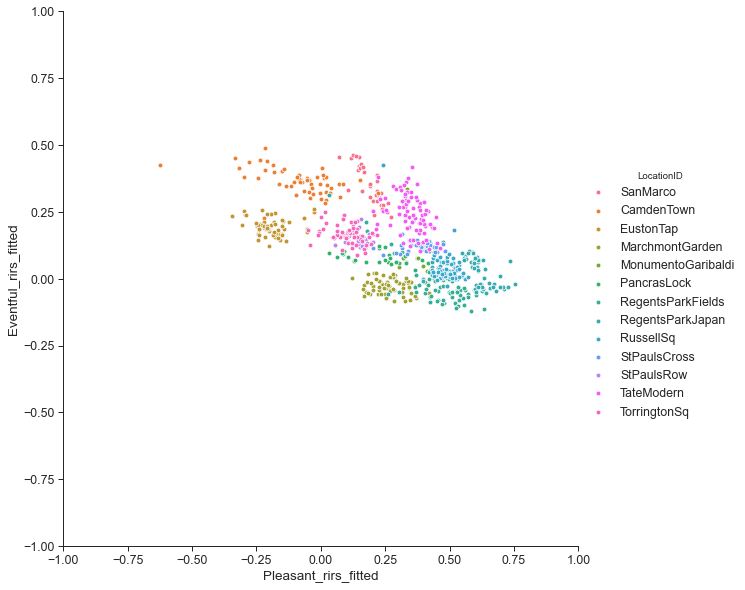

In [5]:
prelockdownData["Pleasant_rirs_fitted"] = Pleasant_rirs_results["final_model_fit"].fittedvalues
prelockdownData["Eventful_rirs_fitted"] = Eventful_rirs_results["final_model_fit"].fittedvalues

ps = sns.pairplot(x_vars=["Pleasant_rirs_fitted"], y_vars=["Eventful_rirs_fitted"], data = prelockdownData, hue="LocationID", size = 8)
ps.set(xlim = (-1,1))
ps.set(ylim= (-1,1))


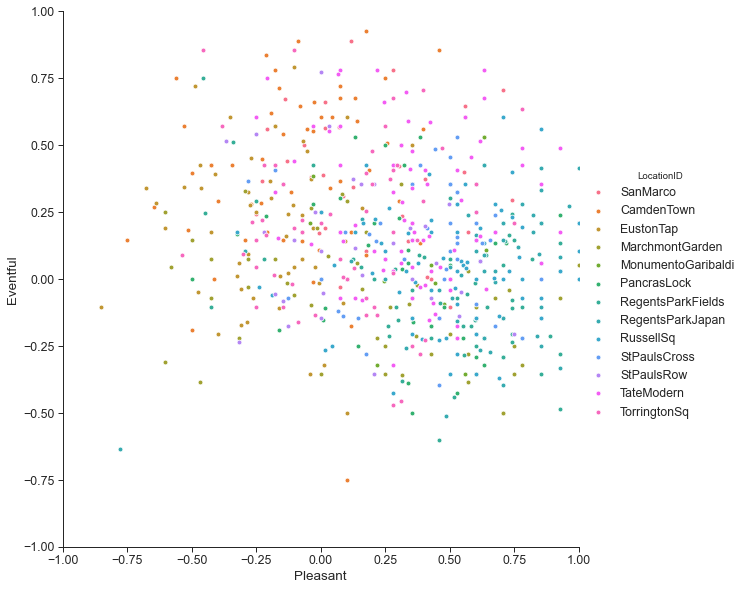

In [6]:
a = sns.pairplot(x_vars=["Pleasant"], y_vars=["Eventful"], data = prelockdownData, hue="LocationID", size = 8)
a.set(xlim = (-1,1))
a.set(ylim= (-1,1))


In [7]:
prelockdownSummary = prelockdownData[["LocationID", "Eventful", "Eventful_rirs_fitted", "Pleasant", "Pleasant_rirs_fitted"]].groupby(['LocationID']).mean()
prelockdownSummary['LocationID'] = prelockdownSummary.index
prelockdownSummary

,Eventful,Eventful_rirs_fitted,Pleasant,Pleasant_rirs_fitted,LocationID
LocationID,,,,,
CamdenTown,0.389827,0.361120,-0.085017,-0.079939,CamdenTown
EustonTap,0.189456,0.193879,-0.212548,-0.195099,EustonTap
MarchmontGarden,-0.045435,-0.027601,0.267471,0.267876,MarchmontGarden
MonumentoGaribaldi,0.057862,0.071834,0.379609,0.377599,MonumentoGaribaldi
PancrasLock,0.064004,0.076539,0.279305,0.277711,PancrasLock
RegentsParkFields,-0.040805,-0.031006,0.466470,0.460391,RegentsParkFields
RegentsParkJapan,0.018787,0.022844,0.632678,0.616848,RegentsParkJapan
RussellSq,0.041965,0.037039,0.489734,0.485003,RussellSq
SanMarco,0.376335,0.351089,0.187516,0.188140,SanMarco


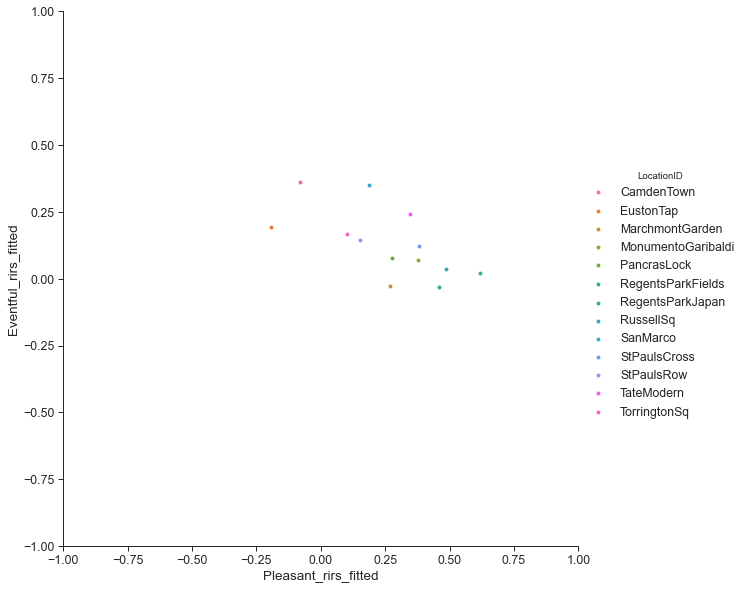

In [8]:
ps = sns.pairplot(x_vars=["Pleasant_rirs_fitted"], y_vars=["Eventful_rirs_fitted"], data = prelockdownSummary, hue="LocationID", size = 8)
ps.set(xlim = (-1,1))
ps.set(ylim= (-1,1))

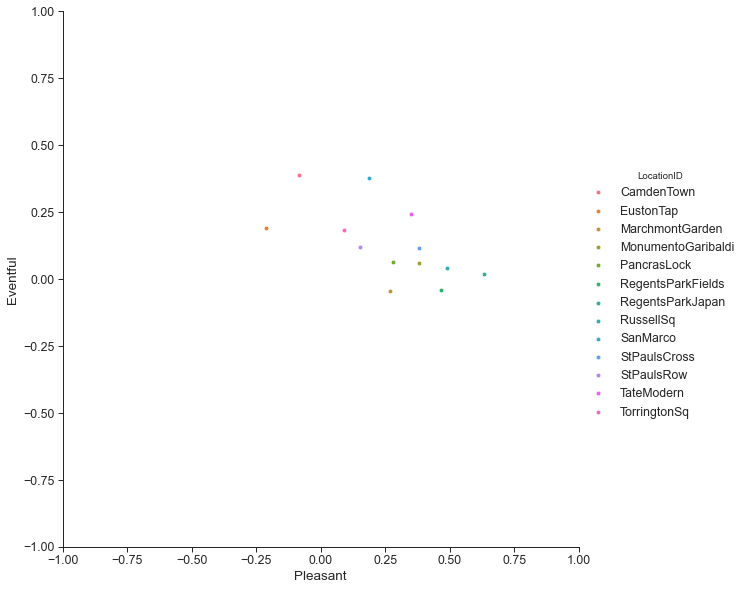

In [9]:
a = sns.pairplot(x_vars=["Pleasant"], y_vars=["Eventful"], data = prelockdownSummary, hue="LocationID", size = 8)
a.set(xlim = (-1,1))
a.set(ylim= (-1,1))

## `Natural` model


Running Forward step feature selection.
1|selected: ['LCeq']  |  aic:  1700.0812
2|selected: ['LCeq', 'S_Min']  |  aic:  1684.1648
3|selected: ['LCeq', 'S_Min', 'N_50']  |  aic:  1677.3548
4|selected: ['LCeq', 'S_Min', 'N_50', 'R_Min']  |  aic:  1674.3716
5|selected: ['LCeq', 'S_Min', 'N_50', 'R_Min', 'SIL_Min']  |  aic:  1673.0358
6|selected: ['LCeq', 'S_Min', 'N_50', 'R_Min', 'SIL_Min', 'S_95']  |  aic:  1672.2302
7|selected: ['LCeq', 'S_Min', 'N_50', 'R_Min', 'SIL_Min', 'S_95']  |  aic:  1672.2302


Natural ~ LCeq + S_Min + N_50 + R_Min + SIL_Min + S_95
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Natural  
No. Observations:     661         Method:                 ML       
No. Groups:           13          Scale:                  0.6754   
Min. group size:      11          Log-Likelihood:         -830.1151
Max. group size:      81          Converged:              No       
Mean group size:      50.8                 

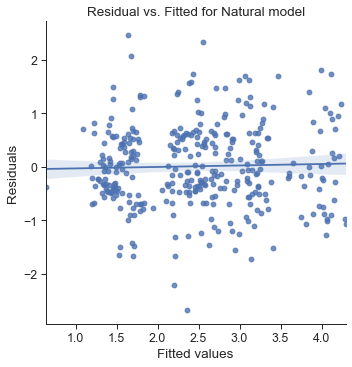

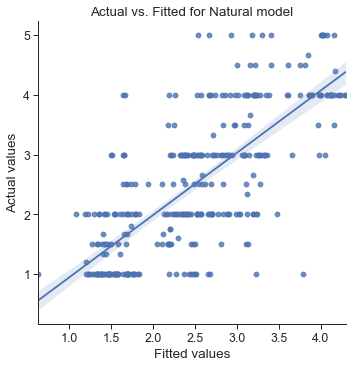

Adj R-sq:  0.4634677254560696


In [10]:
Natural_rirs_results = mlm.mlm_feature_selection(prelockdownData, "Natural", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

Natural_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/Natural_rirs_model_1.pickle")))
Natural_rirs_results["performance"] = mlm.summarise_model(Natural_rirs_results["final_model_fit"], prelockdownData)

## `Traffic` model


Running Forward step feature selection.
1|selected: ['THD_50']  |  aic:  1668.1688
2|selected: ['THD_50', 'I_Min']  |  aic:  1660.8188
3|selected: ['THD_50', 'I_Min', 'S_50']  |  aic:  1654.627
4|selected: ['THD_50', 'I_Min', 'S_50', 'R_5']  |  aic:  1652.2508
5|selected: ['THD_50', 'I_Min', 'S_50', 'R_5', 'LZeq_Max_LZeq_Min']  |  aic:  1649.3728
6|selected: ['THD_50', 'I_Min', 'S_50', 'R_5', 'LZeq_Max_LZeq_Min', 'T_90']  |  aic:  1647.843
7|selected: ['THD_50', 'I_Min', 'S_50', 'R_5', 'LZeq_Max_LZeq_Min', 'T_90', 'SIL_5_SIL_95']  |  aic:  1647.1408
8|selected: ['THD_50', 'I_Min', 'S_50', 'R_5', 'LZeq_Max_LZeq_Min', 'T_90', 'SIL_5_SIL_95', 'S_10']  |  aic:  1646.2394
9|selected: ['THD_50', 'I_Min', 'S_50', 'R_5', 'LZeq_Max_LZeq_Min', 'T_90', 'SIL_5_SIL_95', 'S_10']  |  aic:  1646.2394


Traffic ~ THD_50 + I_Min + S_50 + R_5 + LZeq_Max_LZeq_Min + T_90 + SIL_5_SIL_95 + S_10
                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Var

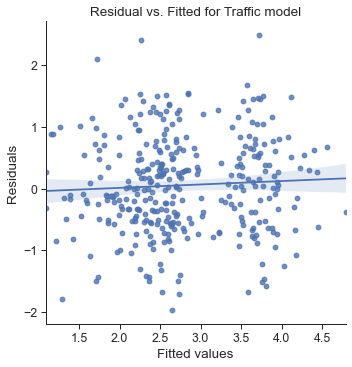

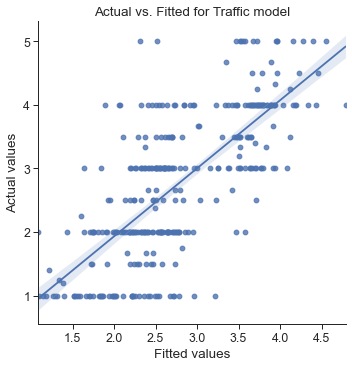

Adj R-sq:  0.44091754897557256


In [11]:
Traffic_rirs_results = mlm.mlm_feature_selection(prelockdownData, "Traffic", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

Traffic_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/Traffic_rirs_model_1.pickle")))
Traffic_rirs_results["performance"] = mlm.summarise_model(Traffic_rirs_results["final_model_fit"], prelockdownData)

## `Human` model


Running Forward step feature selection.
1|selected: ['FS_Min']  |  aic:  1507.4848
2|selected: ['FS_Min', 'I_10_I_90']  |  aic:  1500.3808
3|selected: ['FS_Min', 'I_10_I_90', 'N_5']  |  aic:  1493.6856
4|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5']  |  aic:  1489.6436
5|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5']  |  aic:  1485.921
6|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5', 'FS']  |  aic:  1484.2916
7|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5', 'FS', 'I_Max_I_Min']  |  aic:  1483.2108
8|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5', 'FS', 'I_Max_I_Min', 'SIL_Max_SIL_Min']  |  aic:  1481.8792
9|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5', 'FS', 'I_Max_I_Min', 'SIL_Max_SIL_Min', 'I_5']  |  aic:  1472.206
10|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5', 'FS', 'I_Max_I_Min', 'SIL_Max_SIL_Min', 'I_5', 'THD_10_THD_90']  |  aic:  1469.282
11|selected: ['FS_Min', 'I_10_I_90', 'N_5', 'T_5', 'R_5', 'FS', 'I_Max_I_Min', 'SIL_Max_S

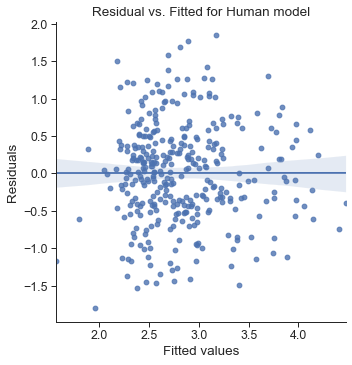

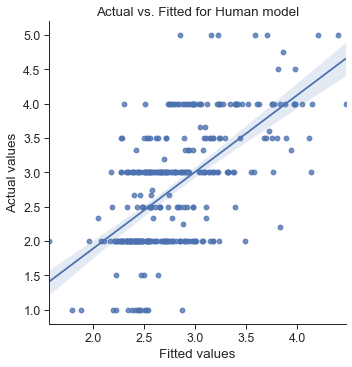

Adj R-sq:  0.4135422642468045


In [4]:
Human_rirs_results = mlm.mlm_feature_selection(prelockdownData, "Human", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

Human_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/Human_rirs_model_1.pickle")))
Human_rirs_results["performance"] = mlm.summarise_model(Human_rirs_results["final_model_fit"], prelockdownData)

## `Other` model


Running Forward step feature selection.
1|selected: ['SpectralCentroid']  |  aic:  1804.1194
2|selected: ['SpectralCentroid', 'S_10']  |  aic:  1798.4494
3|selected: ['SpectralCentroid', 'S_10', 'THD_10']  |  aic:  1792.89
4|selected: ['SpectralCentroid', 'S_10', 'THD_10']  |  aic:  1792.89


Other ~ SpectralCentroid + S_10 + THD_10
                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Other    
No. Observations:        661            Method:                    ML       
No. Groups:              13             Scale:                     0.8228   
Min. group size:         11             Log-Likelihood:            -893.4450
Max. group size:         81             Converged:                 Yes      
Mean group size:         50.8                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.02

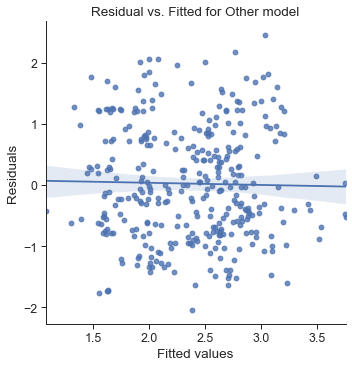

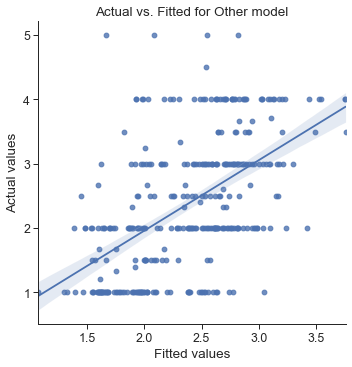

Adj R-sq:  0.2256151733663756


In [5]:
Other_rirs_results = mlm.mlm_feature_selection(prelockdownData, "Other", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

Other_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/Other_rirs_model_1.pickle")))
Other_rirs_results["performance"] = mlm.summarise_model(Other_rirs_results["final_model_fit"], prelockdownData)

## `overall` model


Running Forward step feature selection.
1|selected: ['LCeq']  |  aic:  1511.8338
2|selected: ['LCeq', 'THD_95']  |  aic:  1504.635
3|selected: ['LCeq', 'THD_95', 'R_Min']  |  aic:  1498.2102
4|selected: ['LCeq', 'THD_95', 'R_Min', 'FS_Max_FS_Min']  |  aic:  1495.7588
5|selected: ['LCeq', 'THD_95', 'R_Min', 'FS_Max_FS_Min', 'I_5_I_95']  |  aic:  1493.2038
6|selected: ['LCeq', 'THD_95', 'R_Min', 'FS_Max_FS_Min', 'I_5_I_95']  |  aic:  1493.2038


overall ~ LCeq + THD_95 + R_Min + FS_Max_FS_Min + I_5_I_95
                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       overall  
No. Observations:       661           Method:                   ML       
No. Groups:             13            Scale:                    0.5021   
Min. group size:        11            Log-Likelihood:           -741.6019
Max. group size:        81            Converged:                No       
Mean group size:        50.8                                      

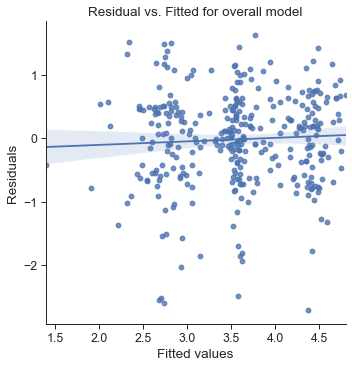

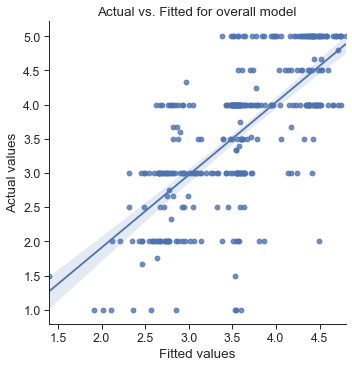

Adj R-sq:  0.41850118047064677


In [6]:
overall_rirs_results = mlm.mlm_feature_selection(prelockdownData, "overall", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

overall_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/overall_rirs_model_1.pickle")))
overall_rirs_results["performance"] = mlm.summarise_model(overall_rirs_results["final_model_fit"], prelockdownData)

## `loudness` model


Running Forward step feature selection.
1|selected: ['LAeq_Min']  |  aic:  1364.1958
2|selected: ['LAeq_Min', 'N_Min']  |  aic:  1357.2616
3|selected: ['LAeq_Min', 'N_Min', 'R_95']  |  aic:  1350.3448
4|selected: ['LAeq_Min', 'N_Min', 'R_95', 'LCeq_50']  |  aic:  1345.9278
5|selected: ['LAeq_Min', 'N_Min', 'R_95', 'LCeq_50', 'S']  |  aic:  1340.2842
6|selected: ['LAeq_Min', 'N_Min', 'R_95', 'LCeq_50', 'S', 'LCeq_Min']  |  aic:  1339.581
7|selected: ['LAeq_Min', 'N_Min', 'R_95', 'LCeq_50', 'S', 'LCeq_Min', 'LCeq_90']  |  aic:  1339.3826
8|selected: ['LAeq_Min', 'N_Min', 'R_95', 'LCeq_50', 'S', 'LCeq_Min', 'LCeq_90', 'S_90']  |  aic:  1338.9334
9|selected: ['LAeq_Min', 'N_Min', 'R_95', 'LCeq_50', 'S', 'LCeq_Min', 'LCeq_90', 'S_90']  |  aic:  1338.9334


loudness ~ LAeq_Min + N_Min + R_95 + LCeq_50 + S + LCeq_Min + LCeq_90 + S_90
               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     loudness 
No. Observations:      661         Met

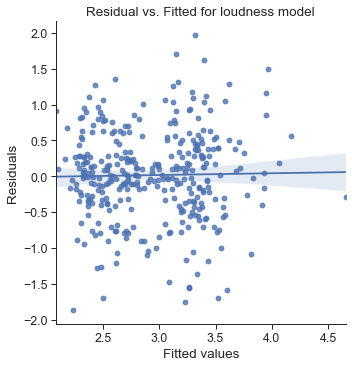

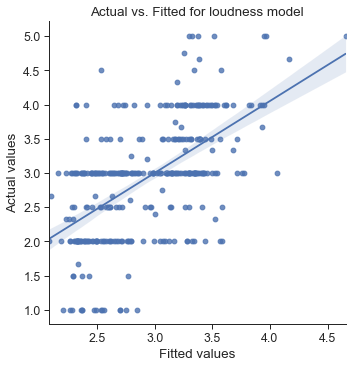

Adj R-sq:  0.265691442673455


In [7]:
loudness_rirs_results = mlm.mlm_feature_selection(prelockdownData, "loudness", acoustic_vars, "LocationID", rand_slope=True, par_cor_selection=False, backward_selection=False, criterion="aic", max_vif=5, verbose=1)

loudness_rirs_results['final_model_fit'].save(str(RESULTS_DIR.joinpath("2020-09-01/loudness_rirs_model_1.pickle")))
loudness_rirs_results["performance"] = mlm.summarise_model(loudness_rirs_results["final_model_fit"], prelockdownData)
loudness_rirs_results["performance"] = mlm.summarise_model(loudness_rirs_results["final_model_fit"], prelockdownData)

### Everything below is trying to solve issues with the model.predict function. 

By default it does not include the random effects terms (who the hell knows why), although the fittedvalues method does. So right now I can't actually run the full model on new data, either to test a train / test split or to predict for the during lockdown data.

In [ ]:
"""
Returns the fitted values for the model.

The fitted values reflect the mean structure specified by the
fixed effects and the predicted random effects.
"""
model_fit = Pleasant_results["rirs_model_fit"]

fit = np.dot(model_fit.model.exog, model_fit.fe_params)
re = model_fit.random_effects
for group_ix, group in enumerate(model_fit.model.group_labels):
    ix = model_fit.model.row_indices[group]
    mat = []
    if model_fit.model.exog_re_li is not None:
        mat.append(model_fit.model.exog_re_li[group_ix])
    for c in model_fit.model.exog_vc.names:
        if group in model_fit.model.exog_vc[c]:
            mat.append(model_fit.model.exog_vc[c][group])
    mat = np.concatenate(mat, axis=1)

    fit[ix] += np.dot(mat, re[group])




In [ ]:
Pleasant_results["rirs_model"].exog_vc.mats

In [ ]:
def fittedvalues(model_fit):
    """
    Returns the fitted values for the model.

    The fitted values reflect the mean structure specified by the
    fixed effects and the predicted random effects.
    """
    fit = np.dot(model_fit.model.exog, model_fit.fe_params)
    re = model_fit.random_effects
    for group_ix, group in enumerate(model_fit.model.group_labels):
        ix = model_fit.model.row_indices[group]

        mat = []
        if model_fit.model.exog_re_li is not None:
            mat.append(model_fit.model.exog_re_li[group_ix])
        for c in model_fit.model.exog_vc.names:
            if group in model_fit.model.exog_vc.names[c]:
                mat.append(model_fit.model.exog_vc.names[c][group])
        mat = np.concatenate(mat, axis=1)

        fit[ix] += np.dot(mat, re[group])

    return fit
fit = fittedvalues(Pleasant_results["rirs_model_fit"])

In [ ]:
fit